# Projet Econométrie Partie 1 - MS BGD 2020 
## ALI Mohammad Fayyaz
## AOUANI El-Habib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import statsmodels.api as sm
import math as m
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.api as smt
from scipy.stats import t,f
import warnings
warnings.filterwarnings('ignore')

## 1. Lire le fichier mroz.txt.

In [2]:
des = pd.read_csv('/Users/fayyazali/Desktop/MS Big Data - Telecom Paris/Econométrie - SES722 /swbook1_3e/textfiles/MROZ.des', sep= '\t', nrows=4)
names_cols = des['MROZ.DES'].str.split().explode().values
df = pd.read_csv('/Users/fayyazali/Desktop/MS Big Data - Telecom Paris/Econométrie - SES722 /swbook1_3e/textfiles/MROZ.raw',
                 names=names_cols,
                 delim_whitespace=True,
                 header=None).drop(['Obs:','753'], axis=1)

In [3]:
#Convertion en float et traitement du '.' en début de float:
def stw(x):
    if str(x).startswith('.'):
        x = x.replace('.','0.')
    else:
        pass
    x = float(x)
    return x

In [4]:
df = df.applymap(stw)

## Ne sélectionner que les observations pour lesquelles la variable wage est strictement positive

In [5]:
#Application du masque des salaire strictement positifs
msk = df['wage'] > 0
df = df[msk]

## 2. Faire les statistiques descriptives du salaire, de l’age et de l’éducation pour l’ensemble des femmes puis, pour les femmes dont le salaire du mari est supérieure au 65ème percentile de l’échantillon, puis pour les femmes dont le salaire du mari est inférieur au 65ème percentile de l’échantillon. Commenter

In [6]:
# Statistiques descriptives du salaire, de l’age et de l’éducation pour l’ensemble des femmes

print(f'Description statistique du salaire des femmes {df["wage"].describe()}')
print('----------------')
print(f"Description statistique de l'age des femmes {df['educ'].describe()}")
print('----------------')
print(f"Description statistique de l'éducation des femmes {df['age'].describe()}")

Description statistique du salaire des femmes count    428.000000
mean       4.177682
std        3.310282
min        0.128200
25%        2.262600
50%        3.481900
75%        4.970750
max       25.000000
Name: wage, dtype: float64
----------------
Description statistique de l'age des femmes count    428.000000
mean      12.658879
std        2.285376
min        5.000000
25%       12.000000
50%       12.000000
75%       14.000000
max       17.000000
Name: educ, dtype: float64
----------------
Description statistique de l'éducation des femmes count    428.000000
mean      41.971963
std        7.721084
min       30.000000
25%       35.000000
50%       42.000000
75%       47.250000
max       60.000000
Name: age, dtype: float64


In [7]:
msk_sup_65 = df['huswage'] > df['huswage'].quantile(0.65)
msk_inf_65 = df['huswage'] <= df['huswage'].quantile(0.65)
df['huswage'].quantile(0.65)

7.8125

In [8]:
print('Salaire des hommes > 65ième percentile \n')
print(f'Description statistique du salaire des femmes {df[msk_sup_65]["wage"].describe()}')
print('----------------')
print(f"Description statistique de l'age des femmes {df[msk_sup_65]['age'].describe()}")
print('----------------')
print(f"Description statistique de l'éducation des femmes {df[msk_sup_65]['educ'].describe()}")

Salaire des hommes > 65ième percentile 

Description statistique du salaire des femmes count    148.000000
mean       5.139315
std        4.351728
min        0.213700
25%        2.561925
50%        4.008050
75%        6.516300
max       25.000000
Name: wage, dtype: float64
----------------
Description statistique de l'age des femmes count    148.00000
mean      42.52027
std        7.35168
min       30.00000
25%       36.00000
50%       43.00000
75%       48.00000
max       59.00000
Name: age, dtype: float64
----------------
Description statistique de l'éducation des femmes count    148.000000
mean      13.520270
std        2.345845
min        5.000000
25%       12.000000
50%       13.000000
75%       16.000000
max       17.000000
Name: educ, dtype: float64


In [9]:
print('Salaire des hommes <= 65ième percentile \n')
print(f'Description statistique du salaire des femmes {df[msk_inf_65]["wage"].describe()}')
print('----------------')
print(f"Description statistique de l'age des femmes {df[msk_inf_65]['age'].describe()}")
print('----------------')
print(f"Description statistique de l'éducation des femmes {df[msk_inf_65]['educ'].describe()}")

Salaire des hommes <= 65ième percentile 

Description statistique du salaire des femmes count    280.000000
mean       3.669390
std        2.458277
min        0.128200
25%        2.151600
50%        3.203550
75%        4.539500
max       22.500000
Name: wage, dtype: float64
----------------
Description statistique de l'age des femmes count    280.000000
mean      41.682143
std        7.906875
min       30.000000
25%       35.000000
50%       41.000000
75%       47.000000
max       60.000000
Name: age, dtype: float64
----------------
Description statistique de l'éducation des femmes count    280.000000
mean      12.203571
std        2.119542
min        6.000000
25%       12.000000
50%       12.000000
75%       12.000000
max       17.000000
Name: educ, dtype: float64


__On remarque que les moyennes des salaire/age/education des femmes diminue en fonction de la partie du 65 parcentile où on est.__

## 3. Faire l'histogramme de la variable wage.

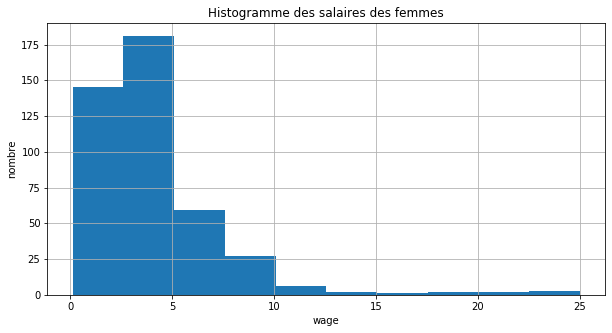

In [10]:
plt.figure(figsize=(10,5))
plt.hist(df['wage'])
plt.grid('true')
plt.xlabel('wage')
plt.ylabel('nombre')
plt.title('Histogramme des salaires des femmes')
plt.show()

## Supprimer les observations qui sont à plus de 3 écart-types de la moyenne et refaire l’histogramme

In [11]:
ecartt = df['wage'].describe()['std']
mean = df['wage'].describe()['mean']

msk_3std = df['wage'] < 3*ecartt + mean

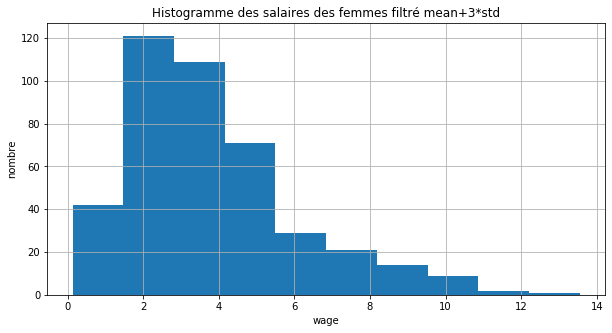

In [12]:
plt.figure(figsize=(10,5))
plt.hist(df[msk_3std]['wage'])
plt.xlabel('wage')
plt.ylabel('nombre')
plt.title('Histogramme des salaires des femmes filtré mean+3*std')
plt.grid('true')
plt.show()

## 4. Calculer les corrélations motheduc et fatheduc. Expliquer le problème de multi-colinéarité. Commenter.

In [13]:
#Pas très corrélé, 0.55 de coefficient de corrélation entre les deux colonnes
np.corrcoef(df['motheduc'],df['fatheduc'])

array([[1.        , 0.55406322],
       [0.55406322, 1.        ]])

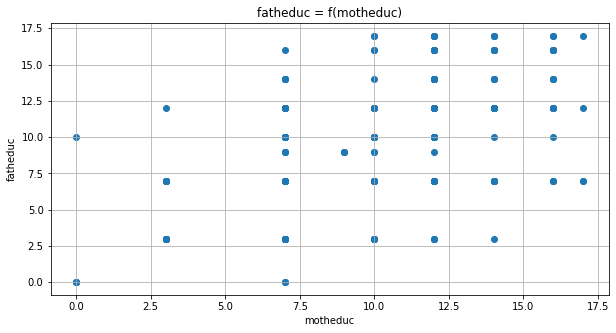

In [14]:
plt.figure(figsize=(10,5))
plt.scatter(df['motheduc'],df['fatheduc'])
plt.grid()
plt.xlabel('motheduc')
plt.ylabel('fatheduc')
plt.title('fatheduc = f(motheduc)')
plt.show()

__Explication multi-colinéarité:__ Nous avons un problème de multicolinéarité lorsque deux ou plusieurs variables (colonnes) de la matrice X sont (quasi) linéairement dépendantes. Ce qui donne det(X'X) proche de 0, ce qui rend difficile le calcul de l'inverse de X'X (valeurs très grandes), nécessaire pour le calcul des écarts types.  
Une solution serait de rajouter des observations ou retirer des variables.  
Avec une covariance de 0.55, nous pensons pouvoir garder les deux variables.

## 5. Faites un graphique en nuage de point entre wage et educ. S'agit-il d'un effet "toute chose étant égale par ailleurs ?"

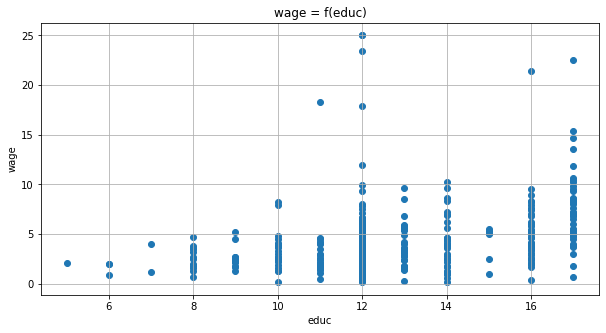

In [15]:
plt.figure(figsize=(10,5))
plt.scatter(df['educ'],df['wage'])
plt.grid('true')
plt.xlabel('educ')
plt.ylabel('wage')
plt.title('wage = f(educ)')
plt.show()

__Effet ceteris paribus:__ Il ne s'agit pas d'un effet "ceteris paribus", car on nous n'avons pas fixé les autres variables, nous ne savons pas si la tendance vue sur le graphe ne serait pas dûe à l'effet d'autres variables.

## 6. Quelle est l'hypothèse fondamentale qui garantit des estimateurs non biaisés ? Expliquer le biais de variable omise.

__Hypothèse fondamentale:__ Espérance du biais (de l'erreur) sachant X = 0 <br>  
__Gauss-Markov:__ MCO est estimateur BLUE (Best Linear Unbiased Estimateur) ssi : <br> 
=> Les erreurs de l'OLS ne sont pas corrélées <br>
=> ont même variances <br>
=> et une espérence nulle

__Biais variable ommise:__ Lorsque l'on omet une variable, l'effet de cette dernière est intégrée dans les résidus. Nous avons alors de très fortes chances de ne plus respecter l'hypothèse fondamentale d'espérance des erreurs nulles sachant X, notamment s'il y a des colinéarités entre les variables omises et nos variables de design.

## 7. Faire la régression du log de wage en utilisant comme variables explicatives une constante, city, educ, exper, nwifeinc, kidslt6, kidsgt6. Commentez l'histogramme des résidus.

In [16]:
# OLS

X = df[['city','educ','exper','nwifeinc','kidslt6','kidsge6']]
y = df['lwage']
const = pd.DataFrame(np.ones(X.shape[0]))
X = pd.concat([const,X], axis=1)

n,k = X.shape

In [17]:
model=sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     12.92
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           2.00e-13
Time:                        21:36:58   Log-Likelihood:                -431.92
No. Observations:                 428   AIC:                             877.8
Df Residuals:                     421   BIC:                             906.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3990      0.207     -1.927      0.0

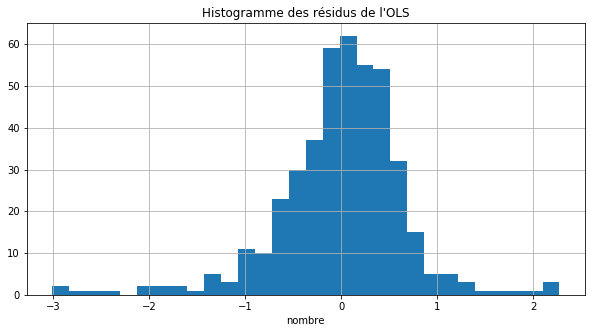

In [18]:
plt.figure(figsize=(10,5))
plt.hist(results.resid, bins=30)
plt.grid('true')
plt.xlabel('valeurs des résidus')
plt.xlabel('nombre')
plt.title("Histogramme des résidus de l'OLS")
plt.show()

__Commentaires:__ les résidus sont centrées sur zéro.  
Elles n'ont pas de tendances normale. Certaines propriétés ne sont possibles que sous l’hypothèse de normalité des résidus.

## 8. Tester l'hypothèse de non significativité de nwifeinc avec un seuil de significativité de 1%, 5% et 10% (test alternatif des deux côtés). Commentez les p-values.

H0: $\beta_{nwifeinc}$ = 0

In [19]:
u = results.resid

In [20]:
beta = results.params
beta

0          -0.398975
city        0.035268
educ        0.102248
exper       0.015488
nwifeinc    0.004883
kidslt6    -0.045303
kidsge6    -0.011704
dtype: float64

In [21]:
# Estimateur non biaisé de la variance des erreurs epsilon
sig2=u.T.dot(u)/(n-k)
# Matrice de variance covariance
Var=sig2*np.linalg.inv(X.T.dot(X))
# les écarts types sont les éléments de la diagonale, tandis que les autres
# éléments représentent les covariances. lorsqu'on divise par les écarts types, on obtient la matrice des corrélations
std=np.sqrt(np.diag(Var))
TStat = (beta['nwifeinc'])/std[4]

#à 10%, la variable nwifeinc est significative
t.sf(TStat,n-k)*2

0.14340798202513919

In [22]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     12.92
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           2.00e-13
Time:                        21:36:58   Log-Likelihood:                -431.92
No. Observations:                 428   AIC:                             877.8
Df Residuals:                     421   BIC:                             906.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3990      0.207     -1.927      0.0

On remarque qu'on retrouve la même p-value entre les deux modèles (OLS manuels et OLS statmodel)

Nous pouvons voir dans results que la p-value vaut 0.143 concernant le test de significativité du coefficient de nwifeinc.  
- Au seuil de 1%: 0.01 < 0.143: On ne rejette pas l'hypothèse H0 
- Au seuil de 5%: 0.05 < 0.143: On ne rejette pas l'hypothèse H0  
- Au seuil de 10%: 0.1 < 0.143: On ne rejette pas l'hypothèse H0  
Pour les 3 seuils proposés, nous ne pouvons rejeter l'hypothèse de non significativité de $\beta_{nwifeinc}$.

## 9. Tester l’hypothèse que le coefficient associé à nwifeinc est égal à 0.01 avec un seuil de significativité de 5% (test à alternatif des deux côtés)

H0: $\beta_{nwifeinc}$ = 0.01

In [23]:
#Méthode 1
y_1 = y - 0.01*df['nwifeinc']
model2 = sm.OLS(y_1,X)
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     11.27
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           1.11e-11
Time:                        21:36:58   Log-Likelihood:                -431.92
No. Observations:                 428   AIC:                             877.8
Df Residuals:                     421   BIC:                             906.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3990      0.207     -1.927      0.0

__Méthode 2:__<br> La statistique de test est: $\frac{(\hat{\beta}_{nwifeinc}-0.01)}{se(\hat{\beta}_{nwifeinc})}$

In [24]:
# Methode 2
t_2 = (beta['nwifeinc']-0.01) / std[4]
print("t2_nwifeinc : ", t_2)
p_val_2 = 2 * (t.cdf(t_2,n-k)) # On multiplie par 2 pour test symétrique
print("p_val_2 : ", p_val_2)

t2_nwifeinc :  -1.5363889855562405
p_val_2 :  0.12519418591699374


On retrouve ainsi les mêmes résultats

__Commentaire:__ le test statistique donne une p-value de 0.125 correspondante à l'hypothèse H0 (relative au coefficient nwifeinc). Nous ne rejettons donc pas l'hypothèse H0

## 10. Tester l’hypothèse jointe que le coefficient de nwifeinc est égal à 0.01 et que celui de city est égal à 0.05.

H0: $\beta_{nwifeinc}$ = 0.01 et $\beta_{city}$ = 0.05

In [25]:
#La somme des carrés des erreurs du modèle non contraint
SSR0 = u.T.dot(u)

In [26]:
# OLS du modèle contraint

X_3 = X.drop(['nwifeinc','city'],axis=1)
y_3 = y - 0.01*df['nwifeinc'] - 0.05*df['city']

model3 = sm.OLS(y_3,X_3)
results3 = model3.fit()
#print(results3.summary())
v = results3.resid

SSR1 = v.T.dot(v)

F = ((SSR1-SSR0)/2)/(SSR0/(n-k))

In [27]:
print(F)
print(f.sf(F,2,n-k))

1.3370704454928417
0.2637267136252716


__Commentaires:__ On ne rejette pas à 5%, l'hypothèse jointe H0 des deux coefficients __$\beta_{nwifeinc}$__ = 0.01 et __$\beta_{city}$__ = 0.05

## 11. Tester l’hypothèse jointe que $\beta_{nwifeinc} + \beta_{city} = 0.1$ et $\beta_{educ} + \beta_{exper} = 0.1$

H0: $\beta_{nwifeinc} + \beta_{city} = 0.1 <=> \beta_{nwifeinc} = 0.1 - \beta_{city}$  
et $\beta_{educ} + \beta_{exper} = 0.1 <=> \beta_{educ} = 0.1 - \beta_{exper}$

In [28]:
# Modèle contraint

y_4 = y - 0.1*df['nwifeinc'] - 0.1*df['educ']

X_int1 = df['city'] - df['nwifeinc']
X_int2 = df['exper'] - df['educ']

X_4 = pd.concat([const,X_int1,X_int2,df['kidslt6'],df['kidsge6']], axis=1)

model4 = sm.OLS(y_4,X_4)
results4 = model4.fit()
u4 = results4.resid

SSR14 = u4.T.dot(u4)

F1 = ((SSR14-SSR0)/2)/(SSR0/(n-k))

print(f'p-value {f.sf(F1,2,n-k)}')

p-value 0.39824353474808405


__Commentaires:__ Nous ne rejettons pas l'hypothèse jointe à 5%

## 12. Faites une représentation graphique de la manière dont le salaire augmente avec l’éducation et l’expérience professionnelle. Commentez

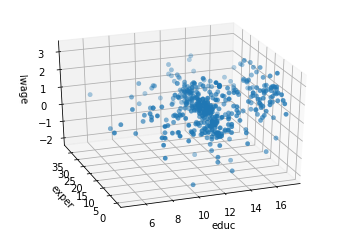

In [29]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

x1=X['educ']
x2=X['exper']

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(x1, x2, y.values.reshape(-1,1), cmap='viridis', linewidth=0.25);
#en bleu les nuages de points

ax.set_xlabel('educ')
ax.set_ylabel('exper')
ax.set_zlabel('lwage')

ax.view_init(30, 250)

__Commentaire:__ On remarque une influence linéaire positive de l'expérience et de l'éducation, sur le log(wage)

# 13. Tester l’égalité des coefficients associés aux variables kidsgt6 et kidslt6. Interprétez.

H0: $\beta_{kidsge6} = \beta_{kidslt6}$

Nous procédons par un changement de variable: <br>
$\theta_{} = \beta_{kidsge6} - \beta_{kidslt6}$ <br> <br>
En injectant $\theta_{}$ dans l'OLS, nous nous rammenons à tester que $\theta_{} = 0$

In [30]:
X_inter = X['kidslt6'] + X['kidsge6']

In [31]:
X_5 = pd.concat([const,X.drop(['kidsge6'],axis=1),X_inter], axis=1)
model5 = sm.OLS(y,X_5)
results5 = model5.fit()
print(results5.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     12.92
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           2.00e-13
Time:                        21:36:58   Log-Likelihood:                -431.92
No. Observations:                 428   AIC:                             877.8
Df Residuals:                     421   BIC:                             906.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1995      0.104     -1.927      0.0

__Commentaires:__ Nous obtenons une pvalue de 0.710 pour la variable kidslt6, nous ne rejettons pas l'égalité des deux coefficients à 5%. Les âges des enfants n'ont pas d'effet différents sur le log(wage).

## 14. Faire le test d'hétéroscédasticité de forme linéaire en donnant la p-valeur. Déterminer la ou les sources d’hétéroscédasticité et corriger avec les méthodes vues en cours. Comparer les écarts-types des coefficients estimés avec ceux obtenus à la question 7. Commenter.

__H0:__ homoscédasticité des erreurs

### - OLS sur log(wage)

In [32]:
# Hétérocédasticité
y = df['lwage']
X = df[['city','educ','exper','nwifeinc', 'kidslt6', 'kidsge6']]

n,k = X.shape
const=pd.DataFrame(np.ones(n))
X = pd.concat([const,X], axis=1)

model=sm.OLS(y,X,hasconst=True)
results = model.fit()
#print(results.summary())

## OLS sur les résidus au carré
u = results.resid
model_ht=sm.OLS(u**2,X,hasconst=True)
results_ht = model_ht.fit()
print(results_ht.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.009
Date:                Sun, 12 Apr 2020   Prob (F-statistic):             0.0633
Time:                        21:36:59   Log-Likelihood:                -622.39
No. Observations:                 428   AIC:                             1259.
Df Residuals:                     421   BIC:                             1287.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.4519      0.323      1.398      0.1

__Commentaires:__ avec une pvalue de 0.0633, nous ne rejettons pas l'homoscédasticité à 5%. Nous allons voir dans la suite, comment améliorer cette homoscédasticité

### - OLS sur wage

In [33]:
# Hétérocédasticité
y = df['wage']
X = df[['city','educ','exper','nwifeinc', 'kidslt6', 'kidsge6']]

n,k = X.shape
const=pd.DataFrame(np.ones(n))
X = pd.concat([const,X], axis=1)

model=sm.OLS(y,X)
results = model.fit()
#print(results.summary())

## OLS sur les résidus au carré
u = results.resid
model_ht=sm.OLS(u**2,X)
results_ht = model_ht.fit()
print(results_ht.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.593
Date:                Sun, 12 Apr 2020   Prob (F-statistic):              0.148
Time:                        21:36:59   Log-Likelihood:                -2207.4
No. Observations:                 428   AIC:                             4429.
Df Residuals:                     421   BIC:                             4457.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.4856     13.111      0.113      0.9

__Commentaires:__ Avec un OLS avec wage au lieu de log(wage), nous remarquons que l'homoscédasticité est améliorée, avec une pvalue de 14.8%.

### - WLS: on choisit la variable 'exper' pour calcul des poids, car c'est elle qui est significative dans l'OLS de u2

In [34]:
#WLS
h=np.sqrt(np.log(df['exper']+1))
y = df['wage']
X = df[['city','educ','exper','nwifeinc', 'kidslt6', 'kidsge6']]
X['exper'] = np.log(X['exper']+1)
model=sm.WLS(y,X,weight=1/h)
results = model.fit()


u = results.resid
model_ht=sm.OLS(u**2,X,hasconst=True)
results_ht = model_ht.fit()
print(results_ht.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2.367
Date:                Sun, 12 Apr 2020   Prob (F-statistic):             0.0389
Time:                        21:36:59   Log-Likelihood:                -2199.3
No. Observations:                 428   AIC:                             4411.
Df Residuals:                     422   BIC:                             4435.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
city           6.8195      4.363      1.563      0.1

__Commentaires:__ Avec WLS et les poids définis comme étant $\sqrt{\log{(exper+1)}}$, nous rejetons désormais l'homocédasticité à 5%.

### - OLS sur deux groupes: OLS sur deux groupes de la variable 'exper', car c'est elle qui est significative dans le test d'hétérocédasticité

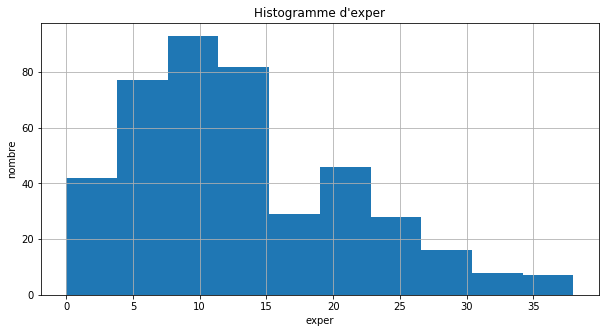

In [35]:
plt.figure(figsize=(10,5))
df['exper'].hist()
plt.grid('true')
plt.xlabel('exper')
plt.ylabel('nombre')
plt.title("Histogramme d'exper")
plt.show()

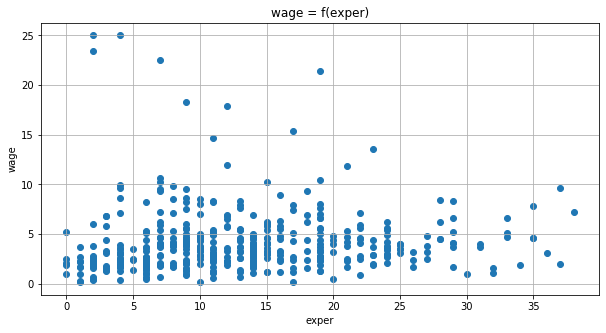

In [36]:
plt.figure(figsize=(10,5))
plt.scatter(df['exper'],df['wage'])
plt.grid('true')
plt.xlabel('exper')
plt.ylabel('wage')
plt.title("wage = f(exper)")
plt.show()

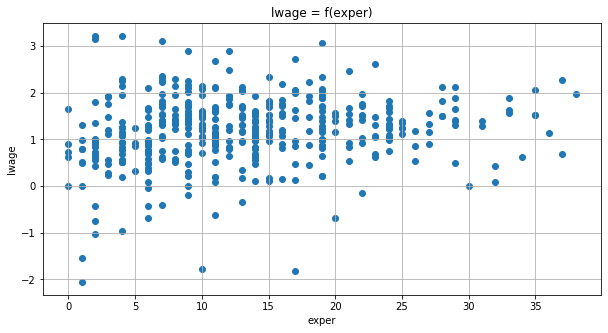

In [37]:
plt.figure(figsize=(10,5))
plt.scatter(df['exper'],df['lwage'])
plt.grid('true')
plt.xlabel('exper')
plt.ylabel('lwage')
plt.title("lwage = f(exper)")
plt.show()

On fixe un seuil de 20 pour définir deux groupes:

In [38]:
s = df['exper'] <= 20

In [39]:
y = df[s]['lwage']
X = df[s][['city','educ','exper','nwifeinc', 'kidslt6', 'kidsge6']]

model=sm.OLS(y, sm.add_constant(X),hasconst=True)
results = model.fit()


u = results.resid
model_ht=sm.OLS(u**2, sm.add_constant(X),hasconst=True)
results_ht = model_ht.fit()
print(results_ht.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.222
Date:                Sun, 12 Apr 2020   Prob (F-statistic):              0.294
Time:                        21:36:59   Log-Likelihood:                -545.34
No. Observations:                 352   AIC:                             1105.
Df Residuals:                     345   BIC:                             1132.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4735      0.400      1.185      0.2

__Commentaires:__ avec une p-value de 29.4%, on a augmenté notre confiance en l'hypothèse d'homocédasticité dans le groupe exper <= 20

In [40]:
y = df[~s]['lwage']
X = df[~s][['city','educ','exper','nwifeinc', 'kidslt6', 'kidsge6']]

model=sm.OLS(y,sm.add_constant(X),hasconst=True)
results = model.fit()


u = results.resid
model_ht=sm.OLS(u**2, sm.add_constant(X),hasconst=True)
results_ht = model_ht.fit()
print(results_ht.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                 -0.041
Method:                 Least Squares   F-statistic:                    0.5091
Date:                Sun, 12 Apr 2020   Prob (F-statistic):              0.799
Time:                        21:36:59   Log-Likelihood:                -19.794
No. Observations:                  76   AIC:                             53.59
Df Residuals:                      69   BIC:                             69.90
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1068      0.327     -0.327      0.7

__Commentaires:__ avec une p-value de 79.9%, on a grandement augmenté notre confiance en l'hypothèse d'homocédasticité dans le groupe exper > 20

La méthode qui a le mieux fonctionné est la création de deux sous-groupes d'exper.

## 15. Tester le changement de structure de la question 8 entre les femmes qui ont plus de 43 ans et les autres : test sur l'ensemble des coefficients. Donnez les p-valeurs

In [41]:
X = df[['city','educ','exper','nwifeinc', 'kidslt6', 'kidsge6']]

In [42]:
X = pd.concat([X,df['age']],axis=1)
X['agesup'] = X['age']>43
X['agesup'] = X['agesup'].astype(int)
X

,city,educ,exper,nwifeinc,kidslt6,kidsge6,age,agesup
0,0.0,12.0,14.0,10.910060,1.0,0.0,32.0,0
1,1.0,12.0,5.0,19.499980,0.0,2.0,30.0,0
2,0.0,12.0,15.0,12.039910,1.0,3.0,35.0,0
3,0.0,12.0,6.0,6.799996,0.0,3.0,34.0,0
4,1.0,14.0,7.0,20.100060,1.0,2.0,31.0,0
...,...,...,...,...,...,...,...,...
423,0.0,10.0,2.0,18.199980,0.0,5.0,36.0,0
424,1.0,12.0,21.0,22.641060,0.0,1.0,40.0,0
425,1.0,13.0,22.0,21.640080,0.0,2.0,43.0,0
426,1.0,12.0,14.0,23.999980,0.0,1.0,33.0,0


### Méthode1: Variables d'intéraction

In [43]:
# Variables d'intéraction:
X['supeduc'] = X['educ']*X['agesup'] 
X['supexper'] = X['exper']*X['agesup'] 
X['supnwif'] = X['nwifeinc']*X['agesup'] 
X['supsge'] = X['kidsge6']*X['agesup'] 
X['supslt'] = X['kidslt6']*X['agesup']
X['supcity'] = X['city']*X['agesup']

In [44]:
X = X.drop(['age'],axis=1)
y = df['lwage']

In [45]:
#On ne garde pas la variable age mais que agesup
X

,city,educ,exper,nwifeinc,kidslt6,kidsge6,agesup,supeduc,supexper,supnwif,supsge,supslt,supcity
0,0.0,12.0,14.0,10.910060,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,12.0,5.0,19.499980,0.0,2.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,12.0,15.0,12.039910,1.0,3.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,12.0,6.0,6.799996,0.0,3.0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,14.0,7.0,20.100060,1.0,2.0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,0.0,10.0,2.0,18.199980,0.0,5.0,0,0.0,0.0,0.0,0.0,0.0,0.0
424,1.0,12.0,21.0,22.641060,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0
425,1.0,13.0,22.0,21.640080,0.0,2.0,0,0.0,0.0,0.0,0.0,0.0,0.0
426,1.0,12.0,14.0,23.999980,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
#Modèle non contraint
X = sm.add_constant(X)
model_14 = sm.OLS(y,X,hasconst=True)
results_14 = model_14.fit()

u_14 = results_14.resid

SSR_04 = u_14.T.dot(u_14)

n4,k4=X.shape

print(SSR_04)
n4,k4

185.9922602587884


(428, 14)

In [47]:
#Modèle contraint
model_14b = sm.OLS(y,X.drop(['agesup','supeduc','supexper','supnwif','supsge','supslt','supcity'],axis=1))
results_14b = model_14b.fit()

#print(results_wage.summary())

u_14b = results_14b.resid

#print(sm.OLS(uu**2,X).fit().summary())

SSR_14b = u_14b.T.dot(u_14b)

print(SSR_14b)

188.58998019263944


In [48]:
F4 = ((SSR_14b-SSR_04)/7)/(SSR_04/(n4-k4))
print(f'statistique de test:{F4}')
print(f'p-value:{f.sf(F4,7,n4-k4)}')

statistique de test:0.8260374852756527
p-value:0.5660364450328104


__Commentaires:__ On ne rejette pas la nullité des 7 paramètres liés aux variables d'intéraction à 5%, donc le fait d'avoir plus de 43ans n'agit pas sur le salaire des femmes, et donc ne modifie pas la structure. Pour rappel l'hypothèse nulle est 'On suppose que les deux régressions sont similaires'.  
  
On confirme ces résultats avec la seconde méthode, en faisant deux régression séparées.

### Méthode2: Test de Chow de changement de structure

__Rappel de l'hypothèse nulle ici__
__H0: On suppose que les paramètres des trois régressions sont les mêmes__

In [49]:
msksup = df['age']>43
Xsup = pd.concat([const[msksup],df[msksup][['city','educ','exper','nwifeinc','kidslt6','kidsge6']]],axis=1)
ysup = df[msksup]['lwage']

modelsup = sm.OLS(ysup,Xsup)
resultsup = modelsup.fit()
usup = resultsup.resid
SSRsup = usup.T.dot(usup)
print(SSRsup)

75.34817069662802


In [50]:
mskinf = df['age']<=43
Xinf = pd.concat([const[mskinf],df[mskinf][['city','educ','exper','nwifeinc','kidslt6','kidsge6']]],axis=1)
yinf = df[mskinf]['lwage']

modelinf = sm.OLS(yinf,Xinf)
resultinf = modelinf.fit()
uinf = resultinf.resid
SSRinf = uinf.T.dot(uinf)
print(SSRinf)

110.64408956216036


In [51]:
print(SSRinf + SSRsup)
print(SSR_04)

185.99226025878838
185.9922602587884


__Remarque:__ La somme des SSR des deux sous régressions est égale à la SSR du modèle contraint de la méthode 1.

In [52]:
X = pd.concat([const,df[['city','educ','exper','nwifeinc','kidslt6','kidsge6']]],axis=1)
y = df['lwage']

n,k = X.shape

model = sm.OLS(y,X)
result = model.fit()

ui = result.resid

SSRi = ui.T.dot(ui)
print(SSRi)

188.58998019263944


In [53]:
ddl1 = k
ddl2 = n - 2*(k)

In [54]:
F14 = ((SSRi - (SSRsup + SSRinf)) / ddl1) / ((SSRinf + SSRsup) / ddl2)
print(f'statistique de test:{F14}')
print(f'p-value:{f.sf(F14,ddl1,ddl2)}')

statistique de test:0.8260374852756618
p-value:0.5660364450328048


__Commentaires:__ Identiquement à la méthode précédente, l'application du test de Chow montre bien que les deux régression sont quasiment similaires, cela rejoint l'effet de nullité des coefficients des nouvelles variables introduite dans la première partie de la question. Ici aussi nous ne rejettons pas l'égalité des coefficients entre les 3 régressions effectuées.

## 16. Ajouter au modèle de la question 7 la variable huseduc. Faire ensuite la même régression en décomposant la variable huseduc en 4 variables binaires construites selon votre choix. Faire le test de non significativité de l’ensemble des variables binaires. Donnez les p-valeurs et commentez.

In [55]:
X17 = pd.concat([const,df[['city','exper','educ','nwifeinc','kidslt6','kidsge6','huseduc']]],axis=1)
y17 = df['lwage']

In [56]:
model17 = sm.OLS(y17, X17)
result17 = model17.fit()
print(result17.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     11.37
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           3.14e-13
Time:                        21:36:59   Log-Likelihood:                -430.96
No. Observations:                 428   AIC:                             877.9
Df Residuals:                     420   BIC:                             910.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3494      0.210     -1.664      0.0

In [57]:
np.sort(X17['huseduc'].unique())

array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.,
       17.])

In [58]:
msk2 = X17.loc[:,'huseduc'].isin([8,9,10,11])
msk3 = X17.loc[:,'huseduc'].isin([12,13,14])
msk4 = X17.loc[:,'huseduc'].isin([15,16,17])

X17.loc[:,'hduc2'] = 0
X17.loc[msk2,'hduc2'] = 1

X17.loc[:,'hduc3'] = 0
X17.loc[msk3,'hduc3'] = 1

X17.loc[:,'hduc4'] = 0
X17.loc[msk4,'hduc4'] = 1

In [59]:
model17 = sm.OLS(y17, X17)
result17 = model17.fit()
print(result17.summary())
n17,k17=sm.add_constant(X17).shape
u17 = result17.resid

SSR17 = u17.T.dot(u17)
print(SSR17)

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     8.093
Date:                Sun, 12 Apr 2020   Prob (F-statistic):           5.53e-12
Time:                        21:36:59   Log-Likelihood:                -430.14
No. Observations:                 428   AIC:                             882.3
Df Residuals:                     417   BIC:                             926.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.4005      0.320     -1.250      0.2

__Tous ces effets sont pris par rapport au niveau d'éducation 1 (educ < 8)__

- l'éducation de l'homme de niveau 2 (8 <= educ <= 11) fait diminuer le salaire de la femme de 20%. L'effet est non significatif, avec une pvalue de 0.367  
- l'éducation de l'homme de niveau 3 (12 <= educ <= 14) fait diminuer le salaire de la femme de 18% aussi. Effet non significatif non plus. Significativité plus faible.  
- l'éducation de l'homme de niveau 4 (15 <= educ <= 17) , fait diminuer le salaire de la femme de 30%. Effet non significatif.  

In [60]:
n17,k17

(428, 11)

__Test de significativité de l'ensemble des variables binaires__

In [61]:
# Modèle contraint:
model17b = sm.OLS(y17, X17.drop(['hduc2','hduc3','hduc4'],axis=1))
result17b = model17b.fit()
#print(result17b.summary())

u17b = result17b.resid

SSR17b = u17b.T.dot(u17b)
print(SSR17b)

187.74229399675636


In [62]:
F17 = ((SSR17b-SSR17)/3)/((SSR17b)/(n17-k17))
print(f'statistique de test:{F17}')
print(f'p-value:{f.sf(F17,3,n17-k17)}')

statistique de test:0.5281956430451739
p-value:0.6631419078733567


__Commentaires:__ Nous ne rejettons pas l'hypothèse de nullité des paramètres binaires à 5%, cela est conforme avec les interprétations des p-value relative au modèle non contraint. En effet l'effet de ces variables sur le salaire n'était pas significatif.